# Assignment 3 Advanced Statistics - Annika Meert


## What is our task?
In this assignment we use the python library pyMC3 to construct a model that follows the following form:

$$ f(x) = a * proteins + b * carbohydrates + c * fats + \epsilon $$

Our given data for proteins, carbohydrates, fats and ATP are the measurements of our patients that contain our searched coefficients a, b, c and the diet values for proteins, carbohydrates and fats that are given by the researches to the patients and are chosen randomly from a uniform distribution between 0 and 1.

I am going to construct the model with MCMC (the package pyMC3).

## How do i specify the model?

Each step that we are taking we are following the Bayes Theorem:

$$ P(H|E) = (P(H) * P(E|H))/P(E) $$

To calculate the Posterior probability (P(H|E)):

For each Parameter that we search for: a, b and c we are setting our guess for the prior distribution.

We set:

a ~ Norm(0,10) <br/>
b ~ Norm(0,10) <br/>
c ~ Norm(0,10) <br/>

Our guess is that all the three parameters are normally distributed with a mean of 0 and a standard deviation of 10.
We can try the model with different guesses for our prior distribution.

When taking a step in our MCMC model we change our parameters to different values. 
With our prior distribution we get the value P(H)(our prior probability) for the given set of parameters in our current step. 

The observed data that we have is the product of the parameters and the diet values for proteins, carbohydrates and fat.
These diet values are randomly drawn from a uniform distribution between 0 and 1.

given_prot ~ Uniform(0,1) <br/>
given_carbo ~ Uniform(0,1) <br/>
given_fat ~ Uniform(0,1) <br/>

With our observed data we can calulate the likelihood of the given event/data given the model with the current parameters (P(E|H)). The product of P(H) and P(E|H) is divided by the probability of an event/data happening in general (P(E)) to calculate the posterior distribution.

In that manner we can calculate the posterior probability for each step. According to the Metropolis Algorithm the next set of parameters is choosen according to the posterior probability. Is the posterior probability higher than for the last step we take the step with a prob. of 1. If it's lower we randomly take the step or not. 
Like that we are going to visit all points in the distribution, but points with higher probability are going to be visited more often --> the visited points are our posterior distribution.

According to the law of large numbers doing that an infinite amount of times it gives us the posterior distributions for our parameters.





In [38]:
import pymc3 as pm
import pandas as pd
print('Running on PyMC3 v{}'.format(pm.__version__))
data = pd.read_csv("diet_and_atp.tsv", header=[0], sep="\t")

Running on PyMC3 v3.7


In [39]:
# specifying the model 
my_model = pm.Model()

with my_model:
    # setting the priors for our unknown model parameters
    a = pm.Normal('a', mu=0, sigma=10)
    b = pm.Normal('b', mu=0, sigma=10)
    c = pm.Normal('c', mu=0, sigma=10)
    
    # the given proteins, carbohydrates and fats follow a uniform distribution
    given_prot = pm.Uniform("given_prot",0,1)
    given_carbo = pm.Uniform("given_carbo",0,1)
    given_fat = pm.Uniform("given_fat", 0,1)
    
    # The observed data is the product of the given_data and our parameters
    # we consider them to be normally distributed
    obs_prot = pm.Normal("obs_prot", mu=given_prot*a,sigma=50, observed = data["Protein"])
    obs_carbo = pm.Normal("obs_carbo", mu=given_carbo*b,sigma=50, observed = data["Carbohydrates"])
    obs_fat = pm.Normal("obs_fat", mu=given_fat*c,sigma=50, observed = data["Fat"])
    
    # Expected value of outcome 
    mu = obs_prot + obs_carbo + obs_fat
    
    # Likelihood (sampling distribution) of observations 
    obs = pm.Normal('obs', mu=mu, sigma= 2, observed = data["ATP"])

## Model fitting 

After specifying the model we have to obtain the posterior estimates for the unknown variables.
A fast way to do that is the maximum a posteriori (MAP) method that is the mode of the posterior distribution.
However, this method just gives a point estimate for the parameters and can be biased if the mode isn't representative of the distribution.

Instead we can also use the Markov Chain Monte Carlo (MCMC) sampling method to obtain the posterior distribution. Therefore we have to specify a step method. As we used in class i'm going to use the Metropolis Algorithm and i'm going to try another one called NUTS(No-U-Turn Sampler).

In [40]:
# Maximum a posteriori (MAP)
map_estimate = pm.find_MAP(model=my_model)

map_estimate


C:\Users\Annika\Anaconda3\lib\site-packages\pymc3\tuning\starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -1,608, ||grad|| = 0.0184: 100%|███████████████████████████████████████████████| 23/23 [00:00<00:00, 870.31it/s]


{'a': array(0.83321516),
 'b': array(2.96448549),
 'c': array(0.15417108),
 'given_prot_interval__': array(6.48687984),
 'given_carbo_interval__': array(9.90205606),
 'given_fat_interval__': array(0.88376867),
 'given_prot': array(0.99847902),
 'given_carbo': array(0.99994993),
 'given_fat': array(0.70760257)}

In [46]:
# using Metropolis 
with my_model:

    # instantiate sampler
    step = pm.Metropolis()

    # draw 50000 posterior samples
    trace_metro = pm.sample(50000, step=step)
    
    burned_trace_metro = trace_metro[10000:]

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [given_fat]
>Metropolis: [given_carbo]
>Metropolis: [given_prot]
>Metropolis: [c]
>Metropolis: [b]
>Metropolis: [a]
Sampling 4 chains: 100%|███████████████████████████████████████████████████| 202000/202000 [03:30<00:00, 960.23draws/s]
The number of effective samples is smaller than 25% for some parameters.


In [52]:
# Posterior Analysis
with my_model:
    # draw 50000 posterior samples
    trace_nuts = pm.sample(50000)
    
    burned_trace_nuts = trace_nuts[10000:]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [given_fat, given_carbo, given_prot, c, b, a]
Sampling 4 chains: 100%|███████████████████████████████████████████████████| 202000/202000 [04:05<00:00, 821.99draws/s]


## Posterior Analysis

After getting the posterior distribution estimates for our unknown variables we want to analyze them.
For that we are using traceplot:


C:\Users\Annika\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\Annika\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\Annika\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\Annika\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument bac

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
a,0.81,7.83,0.05,-14.89,16.75,28385.94,1.0
b,2.95,7.84,0.04,-12.74,18.70,27248.49,1.0
c,0.15,7.89,0.05,-15.43,16.32,25295.18,1.0
given_prot,0.43,0.28,0.00,0.00,0.92,27518.59,1.0
given_carbo,0.45,0.28,0.00,0.00,0.93,26473.05,1.0
given_fat,0.43,0.28,0.00,0.00,0.92,27640.22,1.0


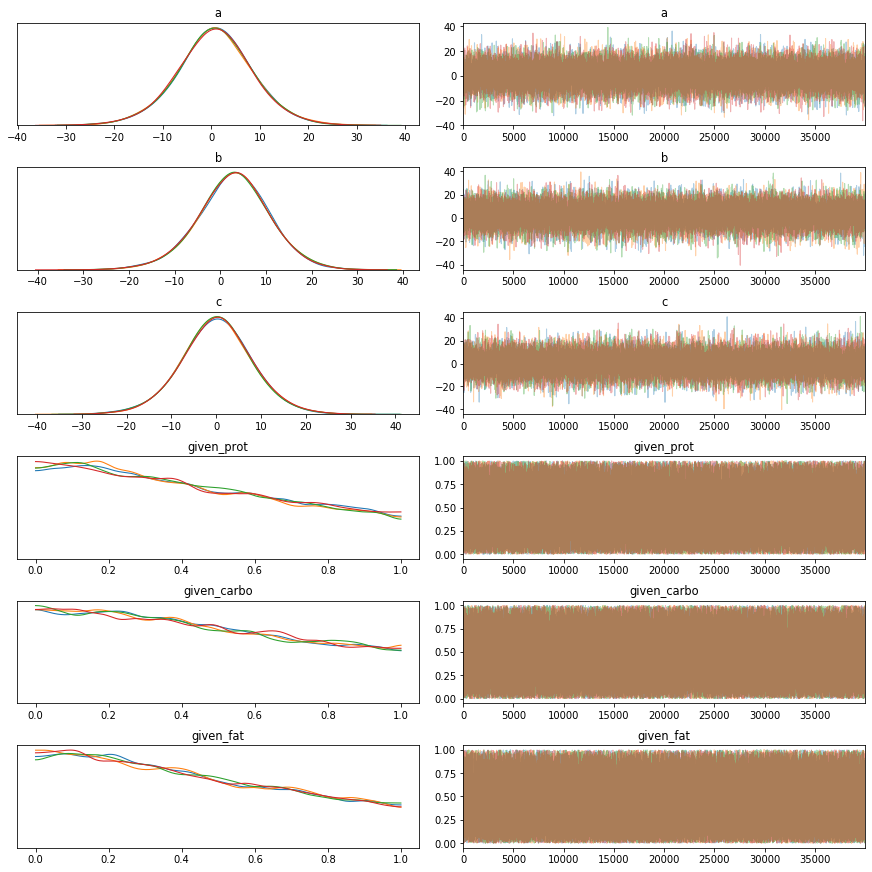

In [53]:
# posterior analysis with traceplot with metropolis alg.

pm.traceplot(burned_trace_metro)

# getting a text-based summary of our outputs with metropolis alg.

pm.summary(burned_trace_metro).round(2)

C:\Users\Annika\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\Annika\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\Annika\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\Annika\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument bac

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
a,0.82,7.87,0.02,-14.75,16.94,147840.98,1.0
b,2.87,7.80,0.02,-13.38,18.10,137230.41,1.0
c,0.11,7.89,0.02,-15.72,16.04,141823.05,1.0
given_prot,0.43,0.28,0.00,0.00,0.92,147846.39,1.0
given_carbo,0.45,0.28,0.00,0.00,0.93,145243.67,1.0
given_fat,0.43,0.28,0.00,0.00,0.92,150361.18,1.0


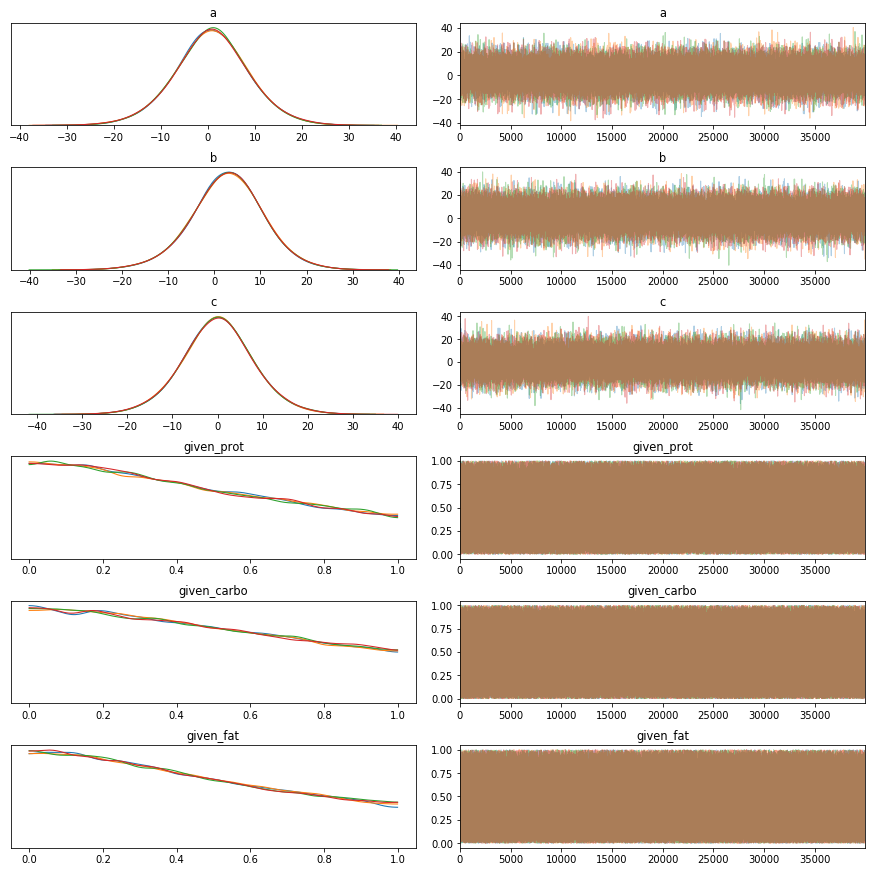

In [54]:
# traceplot with nuts

pm.traceplot(burned_trace_nuts)

#summary with nuts
pm.summary(burned_trace_nuts).round(2)

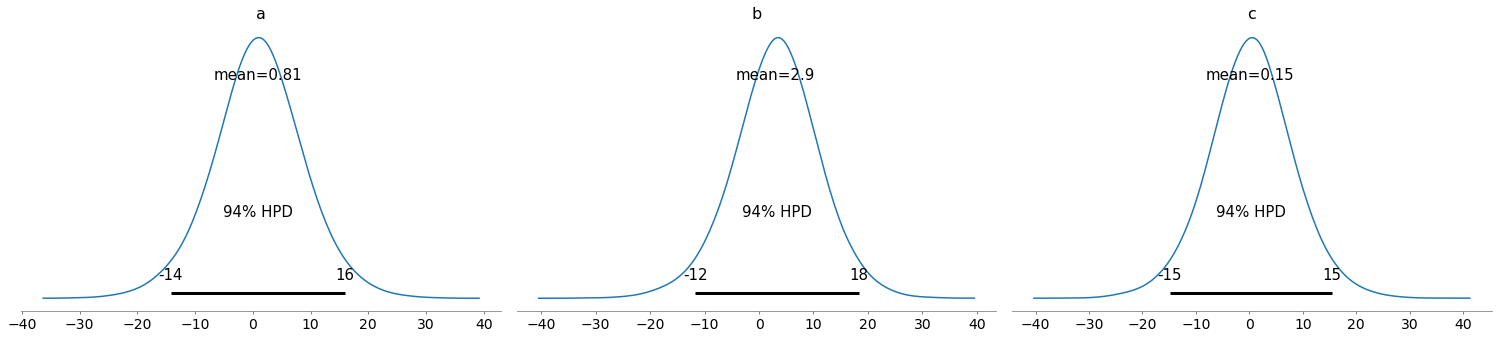

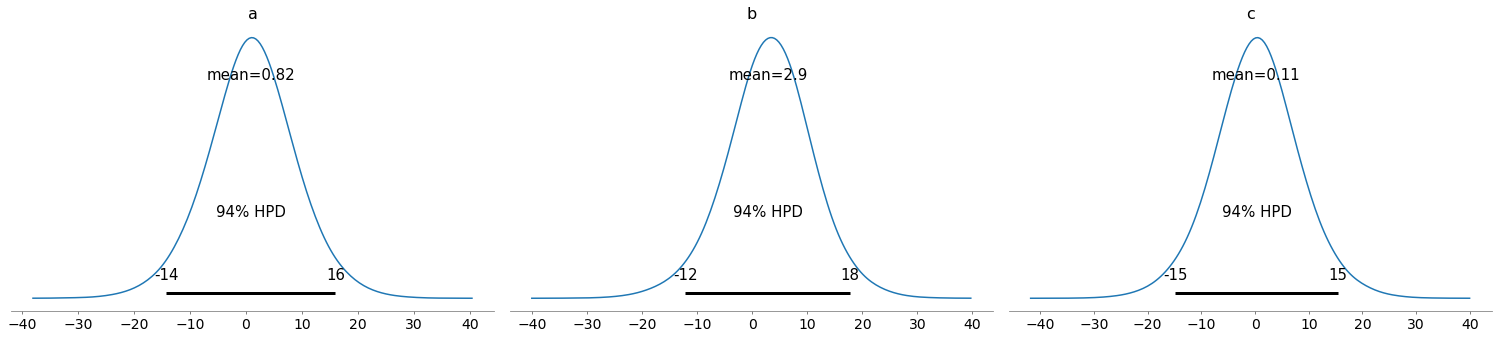

In [60]:
pm.plot_posterior(burned_trace_metro, var_names=["a", "b", "c"]);
pm.plot_posterior(burned_trace_nuts, varnames=["a", "b", "c"]);

While sampling with the metropolis algorithm, states with a higher posterior probability are visited more often than states with a lower posterior probability (Prob. of going to a state with higher prob is 1 while going to a state with lower prob is randomly chosen.) This is why the parameters in the trace plot are going to tend to go to one direction while the actual parameter is not found yet, and the parameters are going to oscillate around the actual value when the parameter is found.

The results of both stepping methods: Metropolis and Nuts are quite similar. <br/>
mean a: 0.81/0.82 <br/>
mean b: 2.9/2.9 <br/>
mean c: 0.15/0.11 <br/>

The results of the parameters are different from the ones in the last assignment because we inserted the uniformly distributed values for the diet of protein, carbohydrates and fats between 0 and 1. And we considered the observed data as the product of both. As a result the parameter value has to be higher.

The expectation value for the ATP depends now not only on our unknown parameters a, b and c but also on the uniformly drawn values for proteins, carbohydrates and fats. This system has 6 unkown variables and only three equations which is why it has an infinite amount of solutions. Given our data we come to a solution. 

The three parameters a, b and c seem to be converging. For following predictions we can use the mean of the posterior distributions of each parameter as the coefficient and multiply it with the uniform factor to get to predict the ATP value.
